# QAOA In The field of smart charging of electric vehicles --- Problem 1: Minimizing the total weighted charging time
Authors: Kevin Shen, Catharina Broocks, Jakob Pforr, Franziska Wilfinger, Jezer Jojo

In [1]:
from IPython.display import Image
from IPython.display import HTML
HTML(open('stylesheet.css').read())

Credits to Aline Lefebvre for the css style sheet template.

<div class = "Prob"> 
We're given $n$ vehicles that need to be charged. Some vehicles are more important than others (ambulances for example) and so each vehicle is assigned a 'weight' $w_i$ accordingly. Each vehicle also has a charging time $t_i$. Now, given $k$ charging ports, the question is this: Which charging port should each vehicle ideally be directed to and in what order?

So there are two sub-questions here. The arguably easier problem is "Given a group of vehicles in a queue waiting on a single charging port, what order should they be in?". Larger weights and shorter charging times should be given preference. So a fair solution is to arrange the vehicles in decreasing order of $\frac{w_i}{t_i}$.

The harder problem that comes before this one is "How would you distribute vehicles to different charging ports in the first place?"
To deal with this problem, we first construct a weighted complete graph where each node represents a vehicle. The weight of the edge connecting nodes $i$ and $j$ is $\min \{w_i t_j, w_j t_i\}$. This weight is the 'cost' incurred if the vehicles represented by these nodes were sent to the same charging port. $w_i t_j$ is the price $i$ pays if it has to wait for $j$, and $w_j t_i$ is the price $j$ pays if it has to wait for $i$. We know we can pick the minimum because we've already solved the problem of ordering in the previous question.

In terms of this graph then, the question becomes "How can we divide this graph into $k$ connected graphs such that the weights of the edges that remain are minimized?", or "How can we divide this graph into $k$ connected graphs such that the weights of the edges that we remove are maximized?". This is the Max-k-cut problem, and it can be solved using QAOA.

## Settings 

### Import packages

<div class='Plain'> The functions used in this notebook are stored in our python package "/Code". External packages to be imported include nextworkx for creating graph objects, scipy for optimization as well as the usual packages numpy and matplotlib. Quantum circuits are defined using the library Qiskit, which is imported in our python files in "/Code". 

In [2]:
from Code.data_processing import *
from Code.Max_k_cut_quantum_functions import *
from Code.Max_k_cut_classical_functions import *
import networkx as nx
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import numpy as np

### Define global parameters and settings

<div class='Plain'> We define here some global parameters and settings which include: <br>
    
n: The total number of nodes
    
n_imp: The number of important nodes, or to say the nodes with which the associated edges have larger weights
    
n_unimp: The number of less important nodes ... smaller weights
    
l: The number of qubits to encode each node
    
k: The number of partitions we are allowed to cut
    
p: The depth of the quantum circuit, ie. the number of layers
    
nshots: The number of shots per iteration
    
init_params: The initial parameters gammas and betas   <br>
This is however unused in the full optimization loop since the educated global guess optimization does not require initial guesses. The init_params here will be used later to demonstrate the performance of a local optimzation alone.

local_optimization_method: The local optimization algorithm to be used <br>
Good candidates include 
'Powell', 'COBYLA', 'Nelder-Mead', 'BFGS'

In [3]:
n_imp = 3 
n_unimp = 2
n = n_imp + n_unimp 
l = 2
k = 2**l 
p = 3
nshots = 512
init_params = [np.pi/8, np.pi]*p
local_optimization_method = 'Powell'

### Generate sample problem

<div class='Plain'> Let's generate a sample max-4-cut problem on which we will illustrate the implementation of the QAOA algorithm.

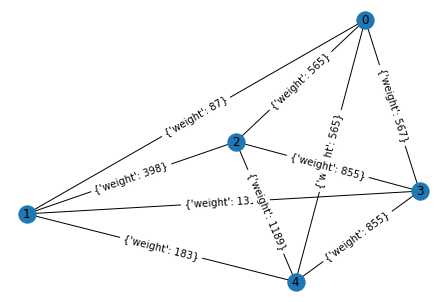

In [4]:
G = generate_data(n_unimp, n_imp)
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True)
nx.draw_networkx_edge_labels(G, pos)
plt.show()

<div class='Plain'> We can equivalently have a weight-matrix representation for this problem

<div class='Rmk'> As suggested in the paper, it is preferred to normalize the weight matrix which would help confine the parameters within a small range and simplify the function landscape.

In [5]:
weights = get_weight_matrix(G)            # Obtain the weight matrix
R = compute_normalization_scale(weights)  # The normalization scale suggested by the paper
rescaled_weights = weights / R            # The rescaled weight matrix

print('original weight matrix =', weights)
print('normalization factor =', R)
print('rescaled weight matrix =', rescaled_weights)

original weight matrix = [[   0   87  565  567  565]
 [  87    0  398  131  183]
 [ 565  398    0  855 1189]
 [ 567  131  855    0  855]
 [ 565  183 1189  855    0]]
normalization factor = 7431.25
rescaled weight matrix = [[0.         0.01170732 0.07603028 0.07629941 0.07603028]
 [0.01170732 0.         0.05355761 0.01762826 0.02462574]
 [0.07603028 0.05355761 0.         0.11505467 0.16      ]
 [0.07629941 0.01762826 0.11505467 0.         0.11505467]
 [0.07603028 0.02462574 0.16       0.11505467 0.        ]]


### Optimal result by brute force

<div class='Plain'> Before implementing the QAOA algorithm, we first compute the optimal solution for our sample problem by brute force. This solution would then serve as the reference for us to evaluate our QAOA implementation.

In [6]:
cost_of_graph, partition = brut_force(G,k)  
normalized_cost = cost_of_graph / R

print('original cost =', cost_of_graph)
print('normalized cost =', normalized_cost)

original cost = 5308
normalized cost = 0.7142809083263246


## QAOA Implementation break into parts

<div class='Plain'> We will now break our QAOA solution into parts and illustrate one by one.

### Encoding qubits
<div class = "Exp"> 
To simplify things we constrain our problem such that $k$ is a power of $2$. Let's say $k=2^l$.
We arrange our qubits into $n$ registers where $n$ is the number of vehicles. Each register has $l$ qubits. 

### Initializing qubits
<div class='Implementation'>
Before applying Cost Hamiltonians and Mixer Hamiltonians on the qubits, we wish to bring the qubits into the equal superposition state by applying a Hadamard gate on each qubit.

In [7]:
ib = make_initial_block(n,l)
ib.draw()

┌───┐
q_0: ┤ H ├
     ├───┤
q_1: ┤ H ├
     ├───┤
q_2: ┤ H ├
     ├───┤
q_3: ┤ H ├
     ├───┤
q_4: ┤ H ├
     ├───┤
q_5: ┤ H ├
     ├───┤
q_6: ┤ H ├
     ├───┤
q_7: ┤ H ├
     ├───┤
q_8: ┤ H ├
     ├───┤
q_9: ┤ H ├
     └───┘

### Constructing the Mixer Hamiltonian

<div class = "Implementation">  <br>
For the mixer hamiltonian $H_M$, we pick $\sum\limits_{i=1}^{n}{X}$.
    
The unitary operation for $e^{-i H_M \beta}$ is then implemented by applying $R_X(2\beta)$ gates on every qubit.
The initial state for this mixer is one where every qubit is in the plus state so we start by applying $H$ gates on every qubit.

In [8]:
mb = make_mixing_block(n,l,1)
mb.draw()

┌──────────┐
q_0: ┤ RX(2*β1) ├
     ├──────────┤
q_1: ┤ RX(2*β1) ├
     ├──────────┤
q_2: ┤ RX(2*β1) ├
     ├──────────┤
q_3: ┤ RX(2*β1) ├
     ├──────────┤
q_4: ┤ RX(2*β1) ├
     ├──────────┤
q_5: ┤ RX(2*β1) ├
     ├──────────┤
q_6: ┤ RX(2*β1) ├
     ├──────────┤
q_7: ┤ RX(2*β1) ├
     ├──────────┤
q_8: ┤ RX(2*β1) ├
     ├──────────┤
q_9: ┤ RX(2*β1) ├
     └──────────┘

### Constructing the Cost Hamiltonian
<div class='Exp'>
For the cost hamiltonian,

$H_C=\sum\limits_{1<=u<v<=N}w_{uv}\prod\limits_{j=0}^l\frac{1+Z_{u_j}Z_{v_j}}{2}$

We need to implement the operation $e^{-iH_C \gamma}$.

Since $H_C$ is a diagonal matrix, exponentiation is simple and we can exponentiate terms in this summation individually and multiply them together. Each term in the summation in the $H_C$ expression contains a product of matrices, and each term in the expansion of this product is a tensor product of $Z$ gates and Identity gates. This will always be a diagonal matrix with each entry either being +1 or -1. For each term in the expansion of this product then, we replace +1 entries with $e^{\frac{-i\gamma w}{2^l}}$ and -1 terms with $e^{\frac{i\gamma w}{2^l}}$. <br>
    
Now we need a rule about which entry in the original matrix is +1 and which entry is -1. It can be worked out that the entry on the i-th row/column of this matrix is -1 if the digits of the bitstring representing i add up to an odd number (that is, they ‘bitwise add up’ to 1) and it’s +1 otherwise. So if the matrix is $U=Z_{u_0}\otimes Z_{v_0}\otimes Z_{u_1}\otimes Z_{v_1}$, then $e^{U}|u_0,v_0,u_1,v_1\rangle = (-1)^{u_0⊕v_0⊕u_1⊕v_1}|u_0,v_0,u_1,v_1\rangle$.

<div class='Implementation'> So, what we can do is we can first draw a chain of $CNOT$s from each qubit that’s involved with a $Z$ gate to the next one. This should take $|u_0,v_0,u_1,v_1\rangle$ to $|u_0, (u_0⊕v_0), (u_0⊕v_0⊕u_1), (u_0⊕v_0⊕u_1⊕v_1)\rangle$
Applying an $R_Z(w_{uv}\gamma/2^{l-1})$ to the last qubit leads to a phase of $e^{\frac{-i\gamma w_{uv}}{2^l}}$ if $u_0⊕v_0⊕u_1⊕v_1=0$ and it leads to a phase of $e^{\frac{-i\gamma w_{uv}}{2^l}}$ otherwise. This is exactly what we needed. All we need to do is undo the $CNOT$s by applying them in reverse order.

This then is what we do for each term in the summation of $H_C$.

In [9]:
cb = make_cost_block(n,l,rescaled_weights,1)
cb.draw()

»
q_0: ──■───────────────────────────────────────■─────────■────────────»
       │                                       │       ┌─┴─┐          »
q_1: ──┼────■──────────────────────────────────┼────■──┤ X ├──■───────»
     ┌─┴─┐  │  ┌────────────────────────────┐┌─┴─┐  │  └───┘┌─┴─┐     »
q_2: ┤ X ├──┼──┤ RZ(0.00585365853658537*γ1) ├┤ X ├──┼───────┤ X ├──■──»
     └───┘┌─┴─┐├────────────────────────────┤└───┘┌─┴─┐     └───┘┌─┴─┐»
q_3: ─────┤ X ├┤ RZ(0.00585365853658537*γ1) ├─────┤ X ├──────────┤ X ├»
          └───┘└────────────────────────────┘     └───┘          └───┘»
q_4: ─────────────────────────────────────────────────────────────────»
                                                                      »
q_5: ─────────────────────────────────────────────────────────────────»
                                                                      »
q_6: ─────────────────────────────────────────────────────────────────»
                                                                      »
q_7: ─────────────────────────────────────────────────────────────────»
                                                                      »
q_8: ─────────────────────────────────────────────────────────────────»
                                                                      »
q_9: ─────────────────────────────────────────────────────────────────»
                                                                      »
«                                                            »
«q_0: ──────────────────────────────────────────■────■───────»
«                                             ┌─┴─┐  │       »
«q_1: ─────────────────────────────────────■──┤ X ├──┼────■──»
«                                        ┌─┴─┐└───┘  │    │  »
«q_2: ────────────────────────────────■──┤ X ├───────┼────┼──»
«     ┌────────────────────────────┐┌─┴─┐└───┘       │    │  »
«q_3: ┤ RZ(0.00585365853658537*γ1) ├┤ X ├────────────┼────┼──»
«     └────────────────────────────┘└───┘          ┌─┴─┐  │  »
«q_4: ─────────────────────────────────────────────┤ X ├──┼──»
«                                                  └───┘┌─┴─┐»
«q_5: ──────────────────────────────────────────────────┤ X ├»
«                                                       └───┘»
«q_6: ───────────────────────────────────────────────────────»
«                                                            »
«q_7: ───────────────────────────────────────────────────────»
«                                                            »
«q_8: ───────────────────────────────────────────────────────»
«                                                            »
«q_9: ───────────────────────────────────────────────────────»
«                                                            »
«                                                           »
«q_0: ───────────────────────────────■─────────■────────────»
«                                    │       ┌─┴─┐          »
«q_1: ───────────────────────────────┼────■──┤ X ├──■───────»
«                                    │    │  └───┘  │       »
«q_2: ───────────────────────────────┼────┼─────────┼───────»
«                                    │    │         │       »
«q_3: ───────────────────────────────┼────┼─────────┼───────»
«     ┌───────────────────────────┐┌─┴─┐  │       ┌─┴─┐     »
«q_4: ┤ RZ(0.0380151387720774*γ1) ├┤ X ├──┼───────┤ X ├──■──»
«     ├───────────────────────────┤└───┘┌─┴─┐     └───┘┌─┴─┐»
«q_5: ┤ RZ(0.0380151387720774*γ1) ├─────┤ X ├──────────┤ X ├»
«     └───────────────────────────┘     └───┘          └───┘»
«q_6: ──────────────────────────────────────────────────────»
«                                                           »
«q_7: ──────────────────────────────────────────────────────»
«                                                           »
«q_8: ──────────────────────────────────────────────────────»
«                                                           »
«q_9: ───────────────────────────────────────────────────

### Assemble the quantum ciruit
<div class='Implementation'> Now we have got all building blocks we need. It's time to assemble the above parts together to make a complete parametrized quantum circuit.

In [10]:
circ = make_full_circuit(n,l,rescaled_weights,p)
circ.decompose().draw()

┌───┐                                                                 »
    q_0: ┤ H ├──■───────────────────────────────────────■─────────■────────────»
         ├───┤  │                                       │       ┌─┴─┐          »
    q_1: ┤ H ├──┼────■──────────────────────────────────┼────■──┤ X ├──■───────»
         ├───┤┌─┴─┐  │  ┌────────────────────────────┐┌─┴─┐  │  └───┘┌─┴─┐     »
    q_2: ┤ H ├┤ X ├──┼──┤ RZ(0.00585365853658537*γ0) ├┤ X ├──┼───────┤ X ├──■──»
         ├───┤└───┘┌─┴─┐├────────────────────────────┤└───┘┌─┴─┐     └───┘┌─┴─┐»
    q_3: ┤ H ├─────┤ X ├┤ RZ(0.00585365853658537*γ0) ├─────┤ X ├──────────┤ X ├»
         ├───┤     └───┘└────────────────────────────┘     └───┘          └───┘»
    q_4: ┤ H ├─────────────────────────────────────────────────────────────────»
         ├───┤                                                                 »
    q_5: ┤ H ├─────────────────────────────────────────────────────────────────»
         ├───┤                                                                 »
    q_6: ┤ H ├─────────────────────────────────────────────────────────────────»
         ├───┤                                                                 »
    q_7: ┤ H ├─────────────────────────────────────────────────────────────────»
         ├───┤                                                                 »
    q_8: ┤ H ├─────────────────────────────────────────────────────────────────»
         ├───┤                                                                 »
    q_9: ┤ H ├─────────────────────────────────────────────────────────────────»
         └───┘                                                                 »
meas: 10/══════════════════════════════════════════════════════════════════════»
                                                                               »
«                                                                »
«    q_0: ──────────────────────────────────────────■────■───────»
«                                                 ┌─┴─┐  │       »
«    q_1: ─────────────────────────────────────■──┤ X ├──┼────■──»
«                                            ┌─┴─┐└───┘  │    │  »
«    q_2: ────────────────────────────────■──┤ X ├───────┼────┼──»
«         ┌────────────────────────────┐┌─┴─┐└───┘       │    │  »
«    q_3: ┤ RZ(0.00585365853658537*γ0) ├┤ X ├────────────┼────┼──»
«         └────────────────────────────┘└───┘          ┌─┴─┐  │  »
«    q_4: ─────────────────────────────────────────────┤ X ├──┼──»
«                                                      └───┘┌─┴─┐»
«    q_5: ──────────────────────────────────────────────────┤ X ├»
«                                                           └───┘»
«    q_6: ───────────────────────────────────────────────────────»
«                                                                »
«    q_7: ───────────────────────────────────────────────────────»
«                                                                »
«    q_8: ───────────────────────────────────────────────────────»
«                                                                »
«    q_9: ───────────────────────────────────────────────────────»
«                                                                »
«meas: 10/═══════════════════════════════════════════════════════»
«                                                                »
«                                                               »
«    q_0: ───────────────────────────────■─────────■────────────»
«                                        │       ┌─┴─┐          »
«    q_1: ───────────────────────────────┼────■──┤ X ├──■───────»
«                                        │    │  └───┘  │       »
«    q_2: ───────────────────────────────┼────┼─────────┼───────»
«                                        │    │         │       »
«    q_3: ───────────────────────────────┼────┼─────────┼───────»
«         ┌───────────────────────────┐┌─┴─┐  │       ┌─┴─┐     »
«    q_4: ┤

### Execute the quantum circuit
<div class='Implementation'> Let us execute the circuit with a Qiskit qasm-simulator which runs locally on your pc or laptop. To execute the circuit, we will need to feed the circuit with the parameters we set in the beginning.  

In [11]:
counts, transpiled_circ = run_circuit(circ, init_params, nshots=nshots)
transpiled_circ.decompose().draw()

global phase: -3.635
         ┌─────────┐                                                        »
    q_0: ┤ U2(0,π) ├──■───────────────────────────────────■─────────■───────»
         ├─────────┤  │                                   │       ┌─┴─┐     »
    q_1: ┤ U2(0,π) ├──┼────■──────────────────────────────┼────■──┤ X ├──■──»
         ├─────────┤┌─┴─┐  │  ┌────────────────────────┐┌─┴─┐  │  └───┘┌─┴─┐»
    q_2: ┤ U2(0,π) ├┤ X ├──┼──┤ U1(0.0183898106551598) ├┤ X ├──┼───────┤ X ├»
         ├─────────┤└───┘┌─┴─┐├────────────────────────┤└───┘┌─┴─┐     └───┘»
    q_3: ┤ U2(0,π) ├─────┤ X ├┤ U1(0.0183898106551598) ├─────┤ X ├──────────»
         ├─────────┤     └───┘└────────────────────────┘     └───┘          »
    q_4: ┤ U2(0,π) ├────────────────────────────────────────────────────────»
         ├─────────┤                                                        »
    q_5: ┤ U2(0,π) ├────────────────────────────────────────────────────────»
         ├─────────┤                                                        »
    q_6: ┤ U2(0,π) ├────────────────────────────────────────────────────────»
         ├─────────┤                                                        »
    q_7: ┤ U2(0,π) ├────────────────────────────────────────────────────────»
         ├─────────┤                                                        »
    q_8: ┤ U2(0,π) ├────────────────────────────────────────────────────────»
         ├─────────┤                                                        »
    q_9: ┤ U2(0,π) ├────────────────────────────────────────────────────────»
         └─────────┘                                                        »
meas: 10/═══════════════════════════════════════════════════════════════════»
                                                                            »
«                                                                 »
«    q_0: ───────────────────────────────────────────■────■───────»
«                                                  ┌─┴─┐  │       »
«    q_1: ──────────────────────────────────────■──┤ X ├──┼────■──»
«                                             ┌─┴─┐└───┘  │    │  »
«    q_2: ──■──────────────────────────────■──┤ X ├───────┼────┼──»
«         ┌─┴─┐┌────────────────────────┐┌─┴─┐└───┘       │    │  »
«    q_3: ┤ X ├┤ U1(0.0183898106551598) ├┤ X ├────────────┼────┼──»
«         └───┘└────────────────────────┘└───┘          ┌─┴─┐  │  »
«    q_4: ──────────────────────────────────────────────┤ X ├──┼──»
«                                                       └───┘┌─┴─┐»
«    q_5: ───────────────────────────────────────────────────┤ X ├»
«                                                            └───┘»
«    q_6: ────────────────────────────────────────────────────────»
«                                                                 »
«    q_7: ────────────────────────────────────────────────────────»
«                                                                 »
«    q_8: ────────────────────────────────────────────────────────»
«                                                                 »
«    q_9: ────────────────────────────────────────────────────────»
«                                                                 »
«meas: 10/════════════════════════════════════════════════════════»
«                                                                 »
«                                                           »
«    q_0: ───────────────────────────■─────────■────────────»
«                                    │       ┌─┴─┐          »
«    q_1: ───────────────────────────┼────■──┤ X ├──■───────»
«                                    │    │  └───┘  │       »
«    q_2: ───────────────────────────┼────┼─────────┼───────»
«                                    │    │         │       »
«    q_3: ───────────────────────────┼────┼─────────┼───────»
«         ┌───────────────────────┐┌─┴─┐  │       ┌─┴─┐     »
«    q_4: ┤ U1(0.119428080691555) ├┤ X ├──┼───────┤ X ├──■──»
«

### Extract Results
<div class='Implementation'>
After executing the quantum circuit, we obtain a list of 0s and 1s as results. We are doing exactly the opposite way we encode the qubits. The results will be viewed as the binary representation of the charging port that that register’s corresponding vehicle should go to. We will translate them back to integers and obtain the computed cut solution. The cost of the solution can be then easily evaluated using the weight matrix.

In [12]:
show_distribution(counts, l)

{'[[0], [1, 2, 3], [4]]': 6,
 '[[0], [1], [2], [3, 4]]': 3,
 '[[0], [1, 2], [3], [4]]': 11,
 '[[0], [1], [2, 3, 4]]': 9,
 '[[0, 2, 4], [1], [3]]': 14,
 '[[0, 1, 3], [2], [4]]': 6,
 '[[0, 3], [1, 2, 4]]': 6,
 '[[0, 1], [2], [3], [4]]': 5,
 '[[0, 2, 4], [1, 3]]': 10,
 '[[0, 1], [2, 4], [3]]': 6,
 '[[0, 4], [1, 2], [3]]': 11,
 '[[0, 2], [1, 4], [3]]': 13,
 '[[0, 2, 3], [1], [4]]': 8,
 '[[0, 4], [1, 3], [2]]': 3,
 '[[0, 1, 2, 3], [4]]': 29,
 '[[0], [1, 3], [2, 4]]': 7,
 '[[0, 4], [1], [2], [3]]': 2,
 '[[0, 2, 3], [1, 4]]': 13,
 '[[0, 1, 4], [2], [3]]': 25,
 '[[0], [1, 2], [3, 4]]': 5,
 '[[0, 1, 2], [3, 4]]': 10,
 '[[0], [1, 4], [2, 3]]': 8,
 '[[0], [1, 2, 3, 4]]': 12,
 '[[0], [1], [2, 3], [4]]': 4,
 '[[0, 2], [1], [3, 4]]': 2,
 '[[0, 1, 2], [3], [4]]': 37,
 '[[0, 1], [2, 3], [4]]': 11,
 '[[0, 2], [1, 3], [4]]': 3,
 '[[0], [1, 4], [2], [3]]': 7,
 '[[0], [1, 2, 4], [3]]': 6,
 '[[0, 3, 4], [1], [2]]': 6,
 '[[0, 1, 3], [2, 4]]': 4,
 '[[0, 3], [1, 2], [4]]': 6,
 '[[0, 1, 3, 4], [2]]': 14,
 '[[0

In [13]:
average_cost = compute_cost(counts, l, rescaled_weights, n_counts = nshots) 
print('The average cost from the above distribution is ' + str(average_cost) + ', which gives an approximation ratio of', average_cost/normalized_cost)

The average cost from the above distribution is 0.4386459209419682, which gives an approximation ratio of 0.6141084212509422


### Optimization
<div class='Implementation'> 
We are missing one final piece of building block to complete the QAOA algorithm -- classical optimization. For that there are a number of good candidates. We are using an implementation of Powell's method from Scipy.optimization.minimization

<div class='Rmk'> The implementation of classical optimizer below is just for simple illustration purpose. As a local optimization algorithm, Powell's method usually does't have good performance when used alone unless the initial parameters are wisely chosen. <br>

In [14]:
func_to_optimize = func_to_optimize_wrapper(circ, l, rescaled_weights, nshots=512, simulator='aer_simulator')

In [15]:
res = minimize(func_to_optimize, init_params, method=local_optimization_method)
print('cost', -1*res.fun)
print('approximation_ratio', -1*res.fun / normalized_cost)
print('parameters', res.x)

cost 0.6278377312867947
approximation_ratio 0.8789787378720786
parameters [1.29123768 3.09627592 1.41058642 5.44039254 9.94654575 6.65519837]


<div class='Exp'> In the next section when we run full optimization loops, we follow a more advanced optimization method, suggested in the paper (https://arxiv.org/pdf/2012.14859.pdf). It starts by running differential evolution (DE) on a depth p=1 circuit, also refered as educated global guess (EGG) later in this notebook, a global optimization algorithm which does not require any guesses for the initial parameters. Then, it fixes the two parameters optimized and extends the circuit to depth p=2 which gives two new parameters. Another round of DE is performed. After that comes a round of local optimization, for which we choose Powell's method while in the paper BFGS was the choice. Unlike DE, during local optimization all the previous parameters get updated. The algorithm then goes on with +1 depth and repeats the same process until a maximum depth defined by the user is met. (picture from https://arxiv.org/pdf/2012.14859.pdf)
<img src="pic/opt_algo.png" width=800 height=800 />

## Full QAOA implementation

<div class='Implementation'> Now we are ready to see a full QAOA implementation. We keep record of optimized parameters and costs at each iteration (layer). In the end, we also display the computed approximation ratios.

In [16]:
param_history, cost_history, circ_history = full_optimization_loop(n, l, rescaled_weights, p, 
                                                                   local_optimization_method=local_optimization_method, 
                                                                   optimal_cost=normalized_cost)
param_history
#cost_history
#circ_history[-1].decompose().draw()

1st params [-1.76501483  9.4344433 ]
1st cost 0.6075212888982319
2nd iteration (EGG), params [-1.76501483  1.42388207  9.4344433  11.6656574 ]
2nd iteration (EGG),  cost 0.6186714150546682
2nd iteration (Powell), params [-1.78362768  1.42379119  8.6555187  14.24380962]
2nd iteration (Powell), cost 0.6238320016820842
3th iteration (EGG), params [-1.78362768  1.42379119 -0.04135235  8.6555187  14.24380962 10.4161362 ]
3th iteration (EGG),  cost 0.6325904121110176
3th iteration (Powell), params [-1.85058343  1.43776884 -0.13312071  6.47281883 13.1820467  12.54725974]
3th iteration (Powell), cost 0.6317814339781326
Approximation Ratio Evolution  [0.85053553 0.86614581 0.87337068 0.88563254 0.88449996]


[array([-1.76501483,  9.4344433 ]),
 array([-1.76501483,  1.42388207,  9.4344433 , 11.6656574 ]),
 array([-1.78362768,  1.42379119,  8.6555187 , 14.24380962]),
 array([-1.78362768,  1.42379119, -0.04135235,  8.6555187 , 14.24380962,
        10.4161362 ]),
 array([-1.85058343,  1.43776884, -0.13312071,  6.47281883, 13.1820467 ,
        12.54725974])]

<div class='Implementation'> As the last step we are going to feed the optimal parameters from the final round back into the quantum circuit and analyze the measurements.

In [17]:
circ = make_full_circuit(n,l,rescaled_weights,p)  # building the full circuit
counts, transpiled_circ = run_circuit(circ, param_history[-1], nshots=nshots)  # do a final run with optimal parameters found
show_distribution(counts, l)

{'[[0], [1, 4], [2, 3]]': 1,
 '[[0], [1, 3, 4], [2]]': 6,
 '[[0, 1, 2, 3, 4]]': 2,
 '[[0, 2], [1], [3, 4]]': 6,
 '[[0, 1], [2], [3], [4]]': 4,
 '[[0, 1, 2, 3], [4]]': 3,
 '[[0, 4], [1], [2], [3]]': 14,
 '[[0, 4], [1, 3], [2]]': 8,
 '[[0, 2], [1, 3], [4]]': 10,
 '[[0], [1], [2, 4], [3]]': 18,
 '[[0], [1, 2], [3, 4]]': 4,
 '[[0, 2], [1], [3], [4]]': 3,
 '[[0], [1], [2, 3], [4]]': 28,
 '[[0, 3], [1, 4], [2]]': 4,
 '[[0], [1, 4], [2], [3]]': 20,
 '[[0, 1, 2], [3], [4]]': 5,
 '[[0, 3], [1], [2, 4]]': 2,
 '[[0, 3, 4], [1], [2]]': 2,
 '[[0, 3], [1], [2], [4]]': 84,
 '[[0, 1], [2, 4], [3]]': 4,
 '[[0, 1], [2], [3, 4]]': 3,
 '[[0], [1, 3], [2], [4]]': 117,
 '[[0], [1], [2], [3, 4]]': 127,
 '[[0, 1, 2, 4], [3]]': 3,
 '[[0], [1, 2, 3], [4]]': 4,
 '[[0, 4], [1, 2], [3]]': 6,
 '[[0, 1, 3], [2], [4]]': 5,
 '[[0], [1], [2, 3, 4]]': 1,
 '[[0], [1, 3], [2, 4]]': 4,
 '[[0], [1, 2, 4], [3]]': 1,
 '[[0, 2, 4], [1], [3]]': 3,
 '[[0, 3, 4], [1, 2]]': 2,
 '[[0, 1, 2], [3, 4]]': 2,
 '[[0, 1, 4], [2], [3]]': 3

<div class='Rmk'> It's not done yet. There are still some choices to make regarding how to interpret the distribution obtained above. We will discuss this in the next section.

# Benchmarking

In [18]:
distribution_qaoa = show_distribution(counts, l)

In [19]:
counts_accept=nshots*0.05
len_d = len(distribution_qaoa.values())

In [20]:
Prob_distribution = dict()
for key, value in distribution_qaoa.items():
    if value > counts_accept:
        Prob_distribution[key]=value

In [21]:
import ast

In [22]:
for key, value in Prob_distribution.items():
    P = {}
    participation_data = ast.literal_eval(key)  
    for i in range(len(participation_data)):
        P["P"+str(i)] = participation_data[i]
    a,b = cost(G, P)

# Key muss array sein, kein string

TypeError: cannot unpack non-iterable numpy.int64 object

In [ ]:

print(partition)